# Nuclear Data

This notebook downloads and prepares various databases of nuclear binding energies for use elsewhere.  It should only need to be run once when it will download the data, and defined the interpretation code.  Data is stored in the ``_data`` directory.  The data is presented in terms of importable modules which contain a ``data`` list whos first three elements are ``(Nn, Np, E+dE*1j)`` where the binding energies ``E`` are expressed in units of MeV.  This can be extracted as

```python
import numpy as np
Nn, Np, E = np.asarray(data).T[:3]
```

RMS charge radii are also included.

## Executive Summary

After executing the first part of this notebook, the following mass and charge radii data can be imported:

In [1]:
import numpy as np

In [15]:
import audi2003
Nn, Np, E = np.asarray(audi2003.data).T[:3]

import audi2012
Nn, Np, E = np.asarray(audi2012.data).T[:3]

import angeli2013
Nn, Np, R = np.asarray(angeli2013.data).T[:3]

## Downloading Data

Here we download the raw data files:

We start by loading the data, excluding all excited states and states that depend on trends in the mass surface (TMS). The primary data source is the largest data source of masses from [Audi:2012] and [Wang:2012].  The data file is from:

* http://amdc.in2p3.fr/nubase/nubtab12.asc
* http://amdc.impcas.ac.cn/evaluation/data2012/data/nubase.mas12

Optionally, one can use the previous [Audi:2003] data from:

* http://amdc.in2p3.fr/masstables/Ame2003/mass.mas03

Charge radius data comes from [Angeli:2013]. This data had to be extracted manually from the PDF file:

* ``charge_radii.xls``

[Audi:2012]: http://dx.doi.org/10.1088/1674-1137/36/12/002 (G. Audi, M. Wang, A.H. Wapstra, F.G. Kondev, M. MacCormick, X. Xu, and B. Pfeiffer, "The Ame2012 atomic mass evaluation", Chinese Physics C 36(12), 1287 (2012))
[Wang:2012]: http://dx.doi.org/10.1088/1674-1137/36/12/003 (M. Wang, G. Audi, A.H. Wapstra, F.G. Kondev, M. MacCormick, X. Xu, and B. Pfeiffer, "The Ame2012 atomic mass evaluation", Chinese Physics C 36(12), 1603 (2012))
[Angeli:2013]: http://dx.doi.org/10.1016/j.adt.2011.12.006 (I. Angeli and K.P. Marinova, "Table of experimental nuclear ground state charge radii: An update", Atomic Data and Nuclear Data Tables 99(1), 69 - 95 (2013))

## Loading the Data

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

def display_raw_data(mod):
    Nn, Np, E = np.asarray(mod.data).T[:3]

    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.errorbar(Np, E.real/(Nn+Np), E.imag/(Nn+Np), ls='', fmt='+')
    plt.xlabel('Z')
    plt.ylabel('Experimental Binding energy per nucleon $E/A$ (MeV)')

    plt.subplot(122)
    plt.errorbar(Nn+Np, E.real/(Nn+Np), E.imag/(Nn+Np), ls='', fmt='+')
    plt.xlabel('A')
    
    plt.suptitle(': '.join((mod.description, "%i nuclei" % (len(E),))))
    plt.close()
    return fig

### Audi 2003

In [4]:
%%file audi2003.py
"""Audi 2003 data from 

http://amdc.in2p3.fr/masstables/Ame2003/mass.mas03

Some sanity checks to exclude data with bad errors from
George Betsch's code.
"""
from __future__ import division

import os.path

import numpy as np

__all__ = ['data', 'description']

_DATA_DIR = os.path.join(os.path.dirname(__file__),'_data')
filename = 'mass.mas03'
description = 'Audi 2003 Mass Table'

data = []

skip_header = 39
with open(os.path.join(_DATA_DIR, filename)) as f:
    # The tables list the mass excess M in keV_90
    # The binding energy is Z*M_H + N*M_n - M
    M_H = 7288.97050
    M_n = 8071.31710
    for n, l in enumerate(f):
        if n <= skip_header:
            continue
        def read(n, _l=[l]):
            head = _l[0][:n]
            _l[0] = _l[0][n:]
            return head.strip()
        cc = read(1)
        NZ = int(read(3))
        N = int(read(5))
        Z = int(read(5))
        A = int(read(5))
        assert A == N + Z
        read(1)
        el = read(3)
        o = read(4)
        read(1)
        M = read(13)
        if M.endswith("#"):
            #print("Skip: %s" % (l,))
            continue
        M = float(M)
        M_err = float(read(11))
        E_A = float(read(11))
        E_err_A = float(read(9))
        assert np.allclose((M_H*Z + M_n*N - M)/A, E_A)
        read(1)
        B = read(2)
        beta = read(11)
        beta_err = read(9)
        read(1)
        int(read(3))
        read(1)
        amu = read(12)
        amu_err = read(11)
        
        E = (E_A + 1j*E_err_A) * A / 1000  # Express in MeV
        data.append((N, Z, E))
        
        #x = int(l[7:8])  # 0 for ground states...
        #err = l[8:9]
        #if x != 0 or err == 'W':
        #    #print("Skip: %s" % (l,))
        #    continue
        #M, err = l[18:38].split()
        #if M.endswith('#'):
        #    #print("Skip: %s" % (l,))
        #    continue
            
        # Convert to international MeV's
        #E = (M_H*Z + M_n*N - float(M) + float(err)*1j) / 1000. * (1+6.3e-8)
        #data.append((N, Z, E))


Overwriting audi2003.py


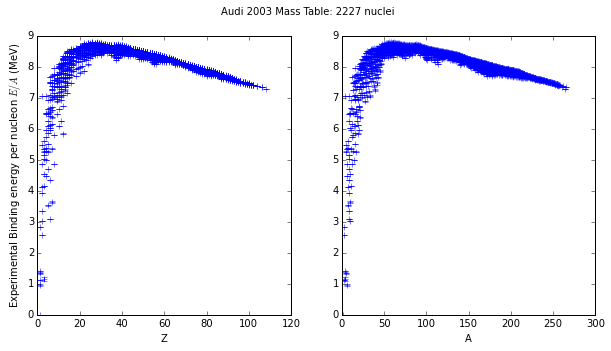

In [21]:
import audi2003;reload(audi2003)
display_raw_data(audi2003)

### Audi 2012

In [6]:
%%file audi2012.py
"""Audi 2012 data from 

http://amdc.in2p3.fr/nubase/nubtab12.asc
http://amdc.impcas.ac.cn/evaluation/data2012/data/nubase.mas12

Some sanity checks to exclude data with bad errors.
"""
from __future__ import division

import os.path

import numpy as np

__all__ = ['data', 'description']

_DATA_DIR = os.path.join(os.path.dirname(__file__),'_data')
filename = 'nubtab12.asc'
description = 'Audi 2012 Mass Table'

data = []
skip_header = 2
with open(os.path.join(_DATA_DIR, filename)) as f:
    # The tables list the mass excess M in keV_90
    # The binding energy is Z*M_H + N*M_n - M
    M_H = 7288.90591
    M_n = 8071.317144

    for n, l in enumerate(f):
        if n <= skip_header:
            continue
        A = int(l[0:3])
        Z = int(l[4:7])
        N = A - Z
        x = int(l[7:8])  # 0 for ground states...
        err = l[8:9]
        if x != 0 or err == 'W':
            #print("Skip: %s" % (l,))
            continue
        M, err = l[18:38].split()
        if M.endswith('#'):
            #print("Skip: %s" % (l,))
            continue
            
        # Convert to international MeV's
        E = (M_H*Z + M_n*N - float(M) + float(err)*1j) / 1000. * (1+6.3e-8)
        data.append((N, Z, E))

Overwriting audi2012.py


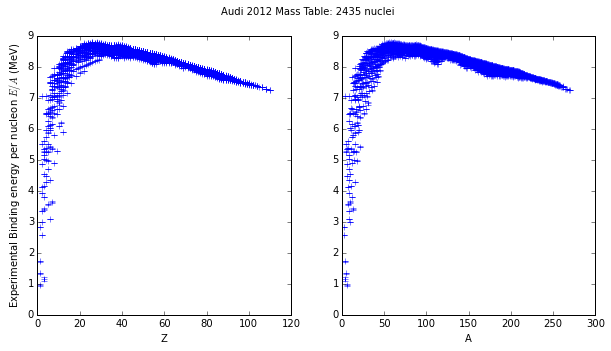

In [22]:
import audi2012;reload(audi2012)
display_raw_data(audi2012)

# Charge Radii

In [8]:
%%file angeli2013.py
"""Angeli 2013 charge radius data from 

  http://dx.doi.org/10.1016/j.adt.2011.12.006
"""
from __future__ import division

import os.path

import numpy as np

__all__ = ['data', 'description']

_DATA_DIR = os.path.join(os.path.dirname(__file__),'_data')
filename = 'rms_charge_radii.dat'
description = 'Angeli 2013 Charge Radii'

data = []
A, N, rms_c, rms_c_err = np.loadtxt(os.path.join(_DATA_DIR, filename)).T
Nn = N
Np = A - N
data = np.array([Nn, Np, rms_c + 1j*rms_c_err]).T

Overwriting angeli2013.py


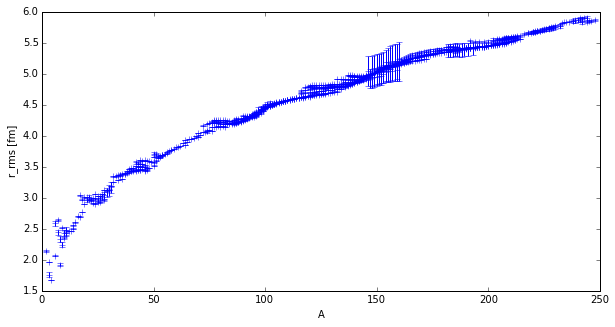

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
import angeli2013;reload(angeli2013)

Nn, Np, R = angeli2013.data.T[:3]
plt.figure(figsize=(10,5))
plt.errorbar(Nn + Np, R.real, R.imag, fmt='+')
plt.xlabel("A")
plt.ylabel("r_rms [fm]")

# Nuclear Binding Energies

In [12]:
import nuclear_binding_energy
Nn, Np, E_exp, E_th = nuclear_binding_energy.binding_energies.T

Populating the interactive namespace from numpy and matplotlib


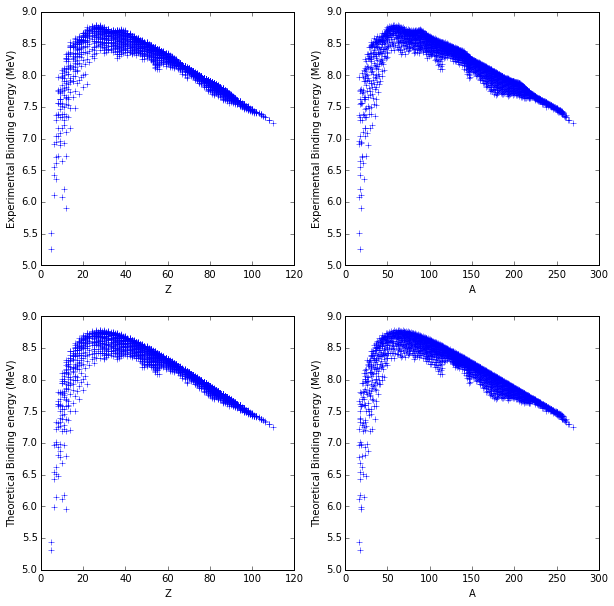

In [13]:
%pylab inline

figure(figsize=(10,10))
subplot(221)
plot(Np, E_exp/(Nn+Np), '+')
xlabel('Z')
ylabel('Experimental Binding energy (MeV)')

subplot(223)
plot(Np, E_th/(Nn+Np), '+')
xlabel('Z')
ylabel('Theoretical Binding energy (MeV)')

subplot(222)
plot(Nn+Np, E_exp/(Nn+Np), '+')
xlabel('A')
ylabel('Experimental Binding energy (MeV)')

subplot(224)
plot(Nn+Np, E_th/(Nn+Np), '+')
xlabel('A')
ylabel('Theoretical Binding energy (MeV)')

# QMC Data for Neutron Matter

This data is from [Wlazowski:2014].  We also include a fit the the UFG equation of state 

$$
  \frac{\mathcal{E}(0, \rho_n)}{\mathcal{E}_{FG}} = 
  \xi - \frac{\zeta}{k_Fa_{nn}} + \zeta_e k_Fr_{nn} + a_2(k_Fr_{nn})^2 + a_3(k_Fr_{nn})^3,\\
  \rho_n = \frac{k_F^3}{3\pi^2}, \quad
  E_F = \frac{\hbar^2 k_F^2}{2m_n}, \quad
  \mathcal{E}_{FG} = \frac{3}{5}\rho_n E_F,\\
  \xi = 0.370(5), \quad
  \zeta = 0.9, \quad
  \zeta_e = 0.127(4), \quad
  a_{nn} =-18.9(4)\text{ fm}, \quad
  r_{nn} = 2.75(11)\text{ fm}.
$$

The coefficients $\xi$ is the best experimental value from [Zurn:2013], which is consistent with the value from [Forbes:2012] which also have $\zeta_e$ and $a_2$ (though the latter is not well determined and is chosen here to approximately fit the QMC data from [Wlazowski:2014]). The parameter $\zeta$ is Tan's Contact from [Hoinka:2013].

The largest factor in the fit are the higher powers in $k_Fr_{nn}$ which fit the QMC data well with either $(a_2 = -0.03, a_3=0)$ or $(a_2=-0.5, a_3=0.0057)$ (tuned by hand). These values of $a_2$ are consistent with the values $a_2 \approx -0.06$ and $a_2 \approx 0.0$ found in [Forbes:2012] though these are simply rough estimates.

[Forbes:2012]: http://dx.doi.org/10.1103/PhysRevA.86.053603 (Michael McNeil Forbes, Stafano Gandolfi, and Alexandros Gezerlis, "Effective-Range Dependence of Resonantly Interacting Fermions", Phys. Rev. A 86, 053603 (2012) [1205.4815](http://arXiv.org/abs/1205.4815))

[Zurn:2013]: http://dx.doi.org/10.1103/PhysRevLett.110.135301 (G. Zürn, T. Lompe, A. N. Wenz, S. Jochim, P. S. Julienne, and J. M. Hutson, "Precise characterization of $^6$Li Feshbach resonances using trap-sideband resolved RF spectroscopy of weakly bound molecules", Phys. Rev. Lett. 110, 135301 (2013) [arXiv:1211.1512](http://arXiv.org/abs/arXiv:1211.1512))

[Wlazowski:2014]: http://arxiv.org/abs/arXiv:1403.3753 (G. Wlazłowski, J. W. Holt, S. Moroz, A. Bulgac, and K. J. Roche, "Auxiliary-Field Quantum Monte Carlo Simulations of Neutron Matter in Chiral Effective Field Theory",  ,  (2014) [arXiv:1403.3753](http://arXiv.org/abs/arXiv:1403.3753))

[Hoinka:2013]: http://dx.doi.org/10.1103/PhysRevLett.110.055305 (Sascha Hoinka, Marcus Lingham, Kristian Fenech, Hui Hu, Chris J. Vale, Joaqu\'\in E. Drut, and Stefano Gandolfi, "Precise Determination of the Structure Factor and Contact in a Unitary Fermi Gas", Phys. Rev. Lett. 110, 055305 (2013) [1209.3830](http://arXiv.org/abs/1209.3830))

In [14]:
import numpy as np
!head -n 9 qmc.txt
data = np.loadtxt('qmc.txt')
rho = data[:, 0]

# Use complex numbers for errors
E_N3LO = data[:, 1] + data[:, 1+3]*1j
E_N3LO_no_3body = data[:, 2] + data[:, 2+3]*1j
E_ev = data[:, 3] + data[:, 3+3]*1j

head: qmc.txt: No such file or directory


IOError: [Errno 2] No such file or directory: 'qmc.txt'

In [11]:
%pylab osx
figure(figsize=(15,10))
clf()
errorbar(rho, E_N3LO.real, E_N3LO.imag, label='N^3L0')
#errorbar(rho, E_N3LO_no_3body.real, E_N3LO_no_3body.imag, label='N^3L0 (no 3-body force)')
#errorbar(rho, E_ev.real, E_ev.imag, label='Evolution Hamiltonian (no 3body)')

# UFG for comparison
import sys;sys.path.append('../simple/')
import units;units.reset_units('natural');nu=units.numericalunits
kF = (3*np.pi**2*rho)**(1./3)
eF = kF**2/2.0 * (nu.hbar**2/nu.mn/nu.MeV)
EFG = 3./5.* eF * rho
a_nn = -18.9 * nu.fm
r_nn = 2.75 * nu.fm

# The third coefficient 0.03 is adjusted by hand to try to fit the QMC results.
# reff from paper with Stefano and Alex + Contact 
xi = 0.37 + 0.127*kF*r_nn - 0.03*(kF*r_nn)**2 - 0.9/(kF*a_nn)  

# Here is an ad-hoc extra term which fits all the QMC data.
xi = 0.37 + 0.127*kF*r_nn - 0.05*(kF*r_nn)**2 + 0.0057*(kF*r_nn)**3 - 0.9/(kF*a_nn)

plot(rho, xi * EFG/rho, '--', label='UFG')

# Polynomial fit starting at kF^2
order = 2
xi = np.polyval(np.polyfit(kF*r_nn, E_N3LO.real/EFG*rho*kF**2, order), kF*r_nn)/kF**2

plot(rho, xi * EFG/rho, ':', label='UFG ord=%i' % (order,))

# A couple of DFT parametrizations
a = -636.19
b = 765.39
gam = 1.35
c = 43.572
alpha = 0.69338
plot(rho, EFG/rho + a*rho + b*rho**gam + c*rho**alpha, '--', label='DFT')

a = -738.12003734
b = 934.224959184
c0 = 137.40709189
c1 = -160.291822383
gam = 7./3 - 1.0
plot(rho, EFG/rho + a*rho + b*rho**gam + c0*rho**(2./3.) + c1*rho, '-.', label='OLD DFT')

xlabel(r'density [fm$^{-3}$]')
ylabel('Energy per neutron [MeV/N]')
ylim(0, 13)
title('AFQMC Energies')
legend(loc='lower right')

Populating the interactive namespace from numpy and matplotlib


NameError: name 'rho' is not defined

In [ ]:
np.polyfit(kF*r_nn, E_N3LO.real/EFG*rho, 3)

# Charge Radii

From [Angeli:2013]. The original table (extracted from the pdf file) is in ``charge_radii.xls``.

[Angeli:2013]: http://dx.doi.org/10.1016/j.adt.2011.12.006 (I. Angeli and K.P. Marinova, "Table of experimental nuclear ground state charge radii: An update", Atomic Data and Nuclear Data Tables 99(1), 69 - 95 (2013) )


In [ ]:
%pylab inline
import numpy as np
data = np.loadtxt('rms_charge_radii.dat')
A, Nn = data[:,:2].T
rms_c = data[:,2] + data[:,3]*1j

In [ ]:
errorbar(A, rms_c.real, rms_c.imag)
xlabel("A")
ylabel("r_rms [fm]")

# Complete Mass Table

This is the largest source of masses from [Audi:2012] and [Wang:2012], but some have very large errors.  Included is George Bertsch's script for extracting useful numbers.  The data file is from http://amdc.in2p3.fr/nubase/nubtab12.asc or http://amdc.impcas.ac.cn/evaluation/data2012/data/nubase.mas12 and has relevant fields: `A, Zx, Symbol, Mass Excess (keV), err` plus additional information. Some data includes a `#` in place of the decimal point: in these cases the value and error are not derived from purely experimental data but use trends in the Mass Surface (TMS) to derive the value and error.

[Audi:2012]: http://dx.doi.org/10.1088/1674-1137/36/12/002 (G. Audi, M. Wang, A.H. Wapstra, F.G. Kondev, M. MacCormick, X. Xu, and B. Pfeiffer, "The Ame2012 atomic mass evaluation", Chinese Physics C 36(12), 1287 (2012))
[Wang:2012]: http://dx.doi.org/10.1088/1674-1137/36/12/003 (M. Wang, G. Audi, A.H. Wapstra, F.G. Kondev, M. MacCormick, X. Xu, and B. Pfeiffer, "The Ame2012 atomic mass evaluation", Chinese Physics C 36(12), 1603 (2012))

<pre><font size="1">
Sample lines
0         1         2         3         4         5         6         7         8         9         0         1         2         3         4
01234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
001 0000   1 n      8071.3171   0.0005                       613.9    s 0.6    1/2+          06          1932 B-=100
001 0010   1H       7288.9705   0.0001                       stbl              1/2+          06 11Be53d  1920 IS=99.9885 70
003 0030   3Li     28670#    2000#                           p-unst                          98          1969 p ?
004 0010   4H      24620      100                            139     ys 10     2-            98 03Me11t  1981 n=100
004 0020   4He      2424.9156   0.0001                       stbl              0+            98          1908 IS=99.999866 
004 0030   4Li     25320      210                             91     ys 9      2-            98 65Ce02t  1965 p=100
005 0010   5H      32890       90                           >910     ys        (1/2+)        02 03Go11t  1987 2n=100
005 0020   5He     11231       20                            700     ys 30     3/2-          02          1937 n=100
005 0030   5Li     11680       50                            370     ys 30     3/2-          02          1941 p=100
005 0040   5Be     37140#    2000#                                             1/2+#         02               p ?
006 0010   6H      41880      250                            290     ys 70     2-#           02          1984 n ?;3n ?
006 0020   6He     17592.09     0.05                         806.92  ms 0.24   0+            02 09Ra33d  1936 B-=100;B-d=0.000165 10
006 0030   6Li     14086.8789   0.0014                       stbl              1+            02          1921 IS=7.59 4
006 0038W  6Lii    17649.76     0.10   3562.88    0.10        56     as 14     0+      T=1   02 81Ro02e  1981 IT=1000
01234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
0         1         2         3         4         5         6         7         8         9         0         1         2         3         4
01234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
286 1133   286Edp 170040#     680#      310#    100#
286 1140   286Fl  171610#     660#                           140     ms 30     0+            05 06Og05td 2004 SF~60;A~40
287 1130   287Ed  170830#     760#                             2#     m                                       A ?;SF ?
287 1140   287Fl  173990#     610#                           520     ms 130                  05 06Og05td 2004 A=100
287 1150   287Ef  177640#     490#                           120     ms 100                  05 04Og03td 2004 A=100
288 1140   288Fl  174720#     850#                           750     ms 140    0+            05 11Ga19td 2004 A=100
288 1150   288Ef  179540#     580#                           190     ms 40                   05 12Og02t  2004 A=100
289 1140   289Fl  177370#     560#                             2.4    s 0.6    5/2+#         05 10Du06td 2004 A=100
289 1141   289Flm 178330#     560#      960#    190#           1.1    s 0.8                     12Ho12td 2012 A=100
289 1150   289Ef  180360#     830#                           340     ms 180                  10 10Og01td 2010 A=100
289 1160   289Lv  184590#     530#                      RN     2#    ms        5/2+#         00 02Ni10i       A ?
290 1150   290Ef  182550#     680#                            60     ms 50                   10 10Og01td 2010 A=100
290 1153   290Efp 182660#     690#      110#    100#
290 1160   290Lv  185030#     660#                             8     ms 3      0+            05 06Og05td 2004 A=100
291 1150   291Ef  183570#     820#                             1#     s                                       A ?;SF ?
291 1160   291Lv  187300#     610#                            28     ms 15                   05 06Og05td 2004 A=100
291 1170   291Eh  191450#     630#                             2#    ms                                       A ?;SF ?
292 1160   292Lv  187920#     850#                            24     ms 12     0+            05 04Og12td 2004 A=100
292 1170   292Eh  193250#     700#                            10#    ms                                       A ?;SF ?
293 1160   293Lv  190480#     560#                            80     ms 40                   05 07Og01td 2004 A=100
293 1161   293Lvm 191410#     560#      930#    200#          80     ms 60                      12Ho12td 2012 A=100
293 1170   293Eh  193970#     830#                            18     ms 8                    10 10Og01td 2010 A=100
293 1180   293Ei  198930#     730#                      RN     1#    ms        1/2+#         00 02Ni10i       A ?
294 1170   294Eh  196040#     690#                           290     ms 230                  10 10Og01td 2010 A=100
294 1180   294Ei  199270#     660#                             1.4   ms 0.7    0+            05 06Og05td 2006 A=100
295 1180   295Ei  201430#     640#                            10#    ms                         04Og05td      A ?
01234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
0         1         2         3         4         5         6         7         8         9         0         1         2         3         4
</font></pre>

In [ ]:
import numpy as np
filename = 'audi2012.dat'
#!head -n 40 $filename 
#!tail -n 40 $filename 

# The tables list the mass excess M in keV_90
# The binding energy is Z*M_H + N*M_n - M
M_H = 7.28890591
M_n = 8.071317144

data = []
skip_header = 2
with open(filename) as f:
    for n, l in enumerate(f):
        if n <= skip_header:
            continue
        A = int(l[0:3])
        Z = int(l[4:7])
        N = A - Z
        x = int(l[7:8])  # 0 for ground states...
        err = l[8:9]
        if x != 0 or err == 'W':
            #print("Skip: %s" % (l,))
            continue
        M, err = l[18:38].split()
        if M.endswith('#'):
            #print("Skip: %s" % (l,))
            continue
            
        # Convert to international GeV's
        M = float(M) / 1000. * (1+6.3e-8)
        err = float(err) / 1000. * (1+6.3e-8)
        
        E = M_H*Z + M_n*N - M + err*1j
        data.append((N, Z, E))

def sift(criterion, data=data):
    """Return all data satisfying `criterion`.
    
    Arguments
    ---------
    criterion : function or str
       The function should take `(N, Z, E)` as an argument and
       return `True` if the data should be used.  If this is a
       str, then it will be evaluated.
    """
    if isinstance(criterion, str):
        criterion = eval("lambda ((N, Z, E)): %s" %(criterion,))
            
    return filter(criterion, data)

def extract(criterion, data=data):
    """Return `(A, Z, E)` for all data satisfying `criterion`.
    """
    N, Z, E = np.array(sift(criterion, data), dtype=complex).T
    A = N + Z
    return A.real, Z.real, E

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
clf()
ax = gcf().add_subplot(111, projection='3d')
EE = extract("N%2 == 0 and Z%2 == 0")
EO = extract("N%2 == 0 and Z%2 == 1")
OE = extract("N%2 == 1 and Z%2 == 0")
OO = extract("N%2 == 1 and Z%2 == 1")
for (A, Z, E), label in zip([EE, EO, OE, OO],
                            ['EE', 'EO', 'OE', 'OO']):
    #errorbar(A, E.real, E.imag, label=label)
    ax.plot_trisurf(A-Z, Z, E.real)
legend(loc="lower right")

In [ ]:
clf()
# Symmetric nuclei
Nn, Np, E = np.array([_d for _d in data 
                      if _d[0] == _d[1] and _d[0] % 2 == 0], 
                     dtype=complex).T
A = Nn + Np
errorbar(Np, E.real/A, E.imag/A, label='(0,0)')

Nn, Np, E = np.array([_d for _d in data 
                      if _d[0] == _d[1] and _d[0] % 2 == 1], 
                     dtype=complex).T
A = Nn + Np
errorbar(Np, E.real/A, E.imag/A, label='(1,1)')

Nn, Np, E = np.array([_d for _d in data 
                      if _d[0] == _d[1]-1 and _d[0] % 2 == 0], 
                     dtype=complex).T
A = Nn + Np
errorbar(Np, E.real/A, E.imag/A, label='(0,1)')

Nn, Np, E = np.array([_d for _d in data 
                      if _d[0] == _d[1]+1 and _d[0] % 2 == 0], 
                     dtype=complex).T
A = Nn + Np
errorbar(Np, E.real/A, E.imag/A, label='(0,-1)')

In [ ]:
%pylab inline
import numpy as sp

# Make table of binding energies from audi2012 mass table.
# G.F. Bertsch, 2012

import sys
lines = open('audi2012.dat').readlines()
data = []
for i in range(4,len(lines)):
   line = lines[i]
   if line[:39].find('#') == -1:
     ss=line.split()
     if ss[1][-1] == '0':
       A = int(ss[0]); Z = int(ss[1][:3])
       N = A - Z
       mm = float(ss[3])/1000.
       err = float(ss[4])/1000.0
       be = 7.2889705 * Z + 8.0713171 * N -mm
       if err <= 0.2:       
          data.append((N,Z,be + err*1j))
     else:
#        print 'bad',line,
       t = 1
data = np.array(data)
Nn, Np, E_binding = data.T